In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True
from scipy import stats
import pastas as ps

ps.show_versions()

import logging, sys
logging.disable(sys.maxsize)

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Pastas version: 1.9.0
Python version: 3.11.4
NumPy version: 1.24.3
Pandas version: 2.2.2
SciPy version: 1.10.1
Matplotlib version: 3.7.1
Numba version: 0.57.0


Definition of the extremes of calibration and validation periods according to the Groundwater Challenge instructions.  
- Calibration period: data used to fit the model.  
- Validation period: data used to test the model's predictive performance.

In [2]:
tmin_cal = "2002-05-01"
tmax_cal = "2016-12-31"
tmin_val = "2017-01-01"
tmax_val = "2021-12-31"

Importing the data.  
- `head`: Time series data of observed groundwater head levels, loaded from a CSV file.
- `stresses`: Time series data of various stressors, loaded from a CSV file.
Data is indexed by dates for time series analysis.  
This specific stresses dataset includes: 
- Precipitation data stored in the `prec` variable in [mm/day].
- Evaporation data stored in the `evap` variable in [mm/day].  
Two different head datasets are provided, they are both imported, nonetheless, they are the exact same and cover the totality of the avaiable head observations.  
Using the complete head observations dataset, two subsets are created, one covering the calibration period (`head_cal`) and one covering the validation period (`head_val`).

In [3]:
path_head = "data/heads.csv"
path_stresses = "data/input_data.csv"

In [4]:
head = pd.read_csv(path_head, index_col=0, parse_dates=True).squeeze()
heads_full = head = pd.read_csv("data/heads_full.csv", index_col=0, 
                       parse_dates=True).squeeze()

stresses = pd.read_csv(path_stresses, index_col=0, parse_dates=True).squeeze()
prec = stresses.iloc[:, 0].rename("prec").dropna()
evap = stresses.iloc[:, 8].rename("evap").dropna()

In [5]:
head_cal = head[(head.index >= tmin_cal) & (head.index <= tmax_cal)]
head_val = heads_full[(heads_full.index >= tmin_val) & (heads_full.index <= tmax_val)]

This plot provides a summary of the observed groundwater head levels and stressors over time.  
The visualization helps identify trends and patterns before model fitting, as well as getting a first idea of the order of magnitude of the head levels and stressors.

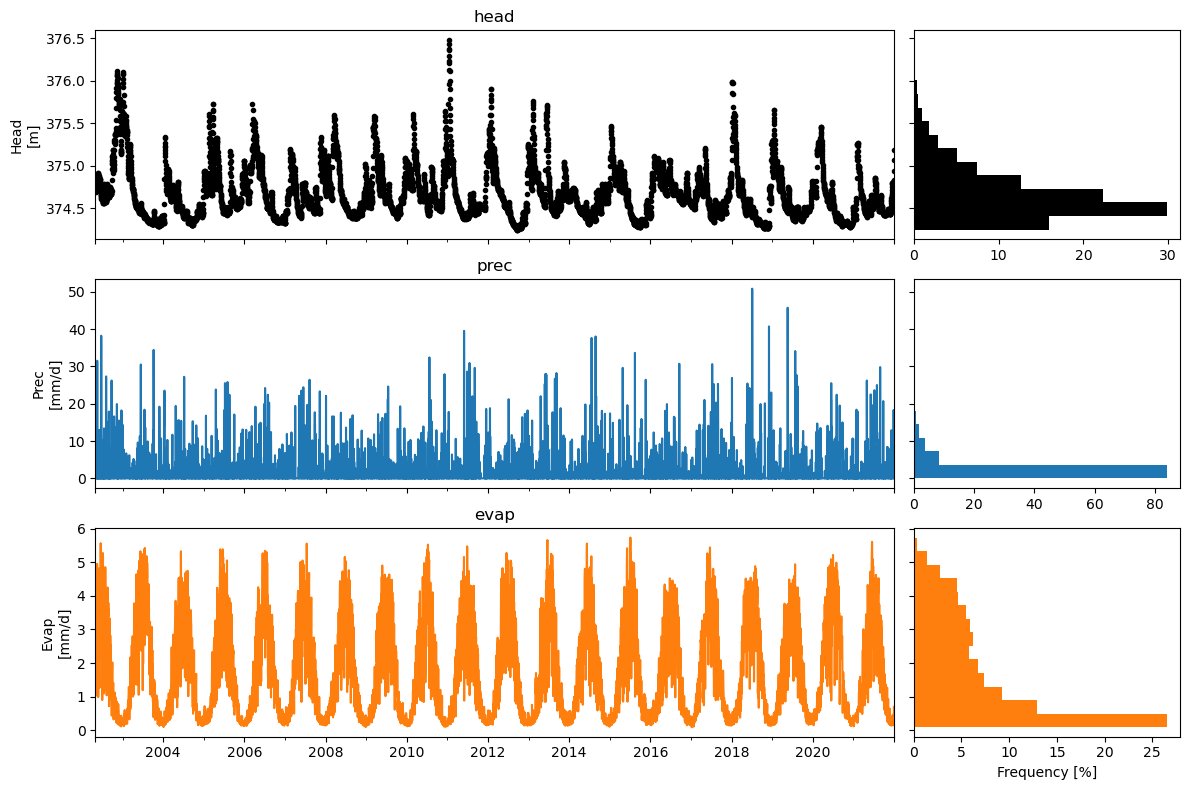

In [6]:
axes = ps.plots.series(
        head=head,
        stresses=[prec, evap],
        tmin=tmin_cal,
        tmax = tmax_val,
        labels=["Head\n[m]", "Prec\n[mm/d]", "Evap\n[mm/d]"],
        figsize = (12, 8))

Validation of imported datasets. This is done to make sure they meet the requirements to be used in PASTAS models.

In [7]:
ps.validate_oseries(head)
ps.validate_stress(prec)
ps.validate_stress(evap)

True

Model is built, a non linear model is chosen, out of all the possible combinations, a recharge FlexModel is chosen with an Exponential response function.\
A noisemodel is added.

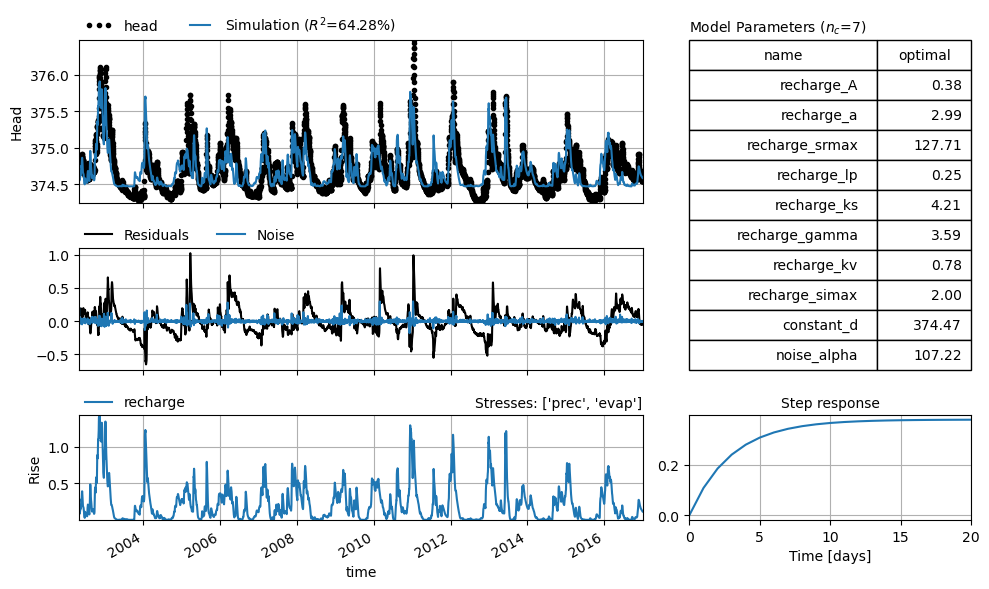

In [15]:
ml = ps.Model(head)
ml.add_noisemodel(ps.ArNoiseModel())

rch = ps.rch.FlexModel()
func = ps.Exponential()
sm = ps.RechargeModel(
    prec,
    evap,
    rfunc = func,
    recharge=rch,
    settings=("prec", "evap"),
)
ml.add_stressmodel(sm)

ml.solve(report=False, tmin=tmin_cal, tmax=tmax_cal, fit_constant = False)
axes = ml.plots.results(figsize=(10, 6))

The resulting fit is not satisfactory yet, the parameters are therefore visualized to identify possible changes that may increase the fit.

In [13]:
ml.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
recharge_A,0.851036,0.00001,85.103621,True,recharge,uniform,0.005015,0.510190
recharge_a,10.000000,0.01000,1000.000000,True,recharge,uniform,0.139084,1.302880
recharge_srmax,250.000000,0.00001,1000.000000,True,recharge,uniform,58.067765,330.677925
recharge_lp,0.250000,0.00001,1.000000,False,recharge,uniform,NaN,0.250000
recharge_ks,100.000000,0.00001,10000.000000,True,recharge,uniform,6.358011,9.767889
recharge_gamma,2.000000,0.00001,20.000000,True,recharge,uniform,0.212613,4.293102
recharge_kv,1.000000,0.25000,2.000000,True,recharge,uniform,0.004884,0.752087
recharge_simax,2.000000,0.00000,10.000000,False,recharge,uniform,NaN,2.000000
constant_d,0.000000,NaN,NaN,False,constant,uniform,NaN,374.427564


Fit report head                    Fit Statistics
nfev    22                     EVP          77.46
nobs    5359                   R2            0.77
noise   False                  RMSE          0.15
tmin    2002-05-01 00:00:00    AICc     -20372.94
tmax    2016-12-31 00:00:00    BIC      -20326.85
freq    D                      Obj          59.69
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (7 optimized)
                   optimal    initial   vary
recharge_A        0.510010    0.60000   True
recharge_a        1.340101    1.30000   True
recharge_srmax  500.000000  800.00000   True
recharge_lp       0.250000    0.25000  False
recharge_ks      55.011237   10.00000   True
recharge_gamma    5.000000    6.00000   True
recharge_kv       0.752634    1.00000   True
recharge_simax    2.000000    2.00000  False
constant_d      374.426133  374.66993   True

Warnings! (3)
Parameter 'recharge_srmax' on lower bound: 5.00e+02
Paramet

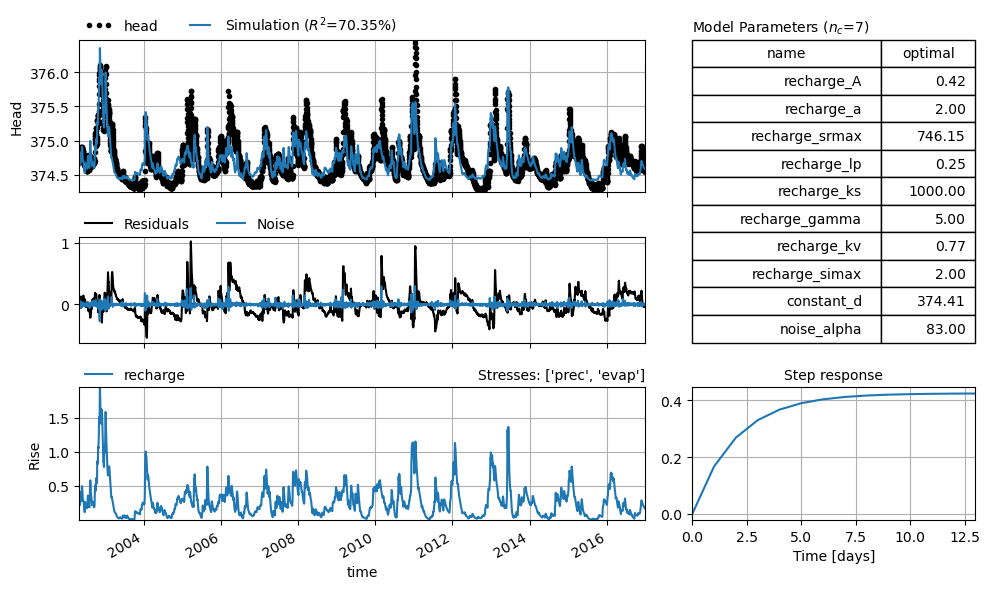

In [24]:
ml.del_noisemodel()

ml.solve(report=True, tmin=tmin_cal, tmax=tmax_cal)

ml.set_parameter(name="recharge_ks", initial=10, vary=True,
                 pmin=1, pmax=1000)

ml.set_parameter(name="recharge_A", initial=0.6, vary=True,
                 pmin=0, pmax=1)

ml.set_parameter(name="recharge_a", initial=1.3, vary=True,
             pmin=0.05, pmax=2)

ml.set_parameter(name="recharge_srmax", initial=300, vary=True,
                 pmin=100, pmax=1000)


ml.set_parameter(name="recharge_gamma", initial=6, vary=True,
                 pmin=5, pmax=10)


ml.add_noisemodel(ps.ArNoiseModel())
ml.solve(initial = False, report=False, tmin=tmin_cal, tmax=tmax_cal, fit_constant = False)
axes = ml.plots.results(figsize=(10, 6))

The head are simulated over the total period including the calibration and validation phases. The 95% prediction interval for the model is computed and shown in a plot along with the simulated and observed head values over the validation period.

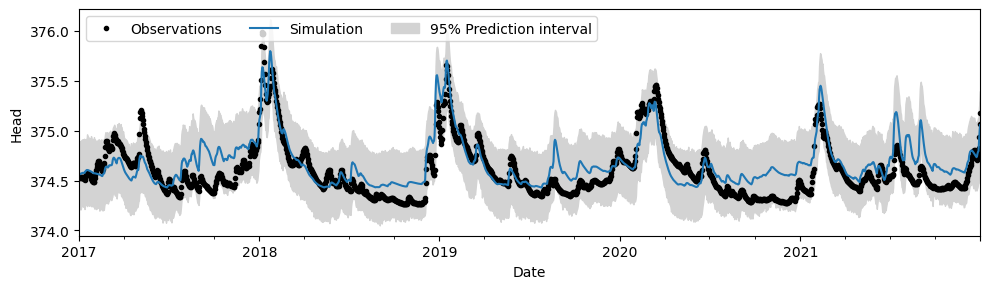

In [25]:
sim_cal = ml.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val = ml.simulate(tmin = tmin_val, tmax = tmax_val)
heads_sim = ml.simulate(tmin = tmin_cal, tmax = tmax_val)

ci_val = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_val, tmax = tmax_val)
ci_cal = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_cal, tmax = tmax_cal)
ci_tot = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_cal, tmax = tmax_val)
ax = ml.plot(figsize=(10, 3), tmin = tmin_val, tmax = tmax_val)
ax.fill_between(ci_val.index, ci_val.iloc[:, 0], ci_val.iloc[:, 1], color="lightgray")
ax.legend(["Observations", "Simulation", "95% Prediction interval"], ncol=3, loc=2)

A comprehensive plot is provided including:
- scatter plot of observed head values over the total period (2002 - 2022).
- simulated head over the total period (2002 - 2022).
- 95% prediction interval over the validation period (2017 - 2022).

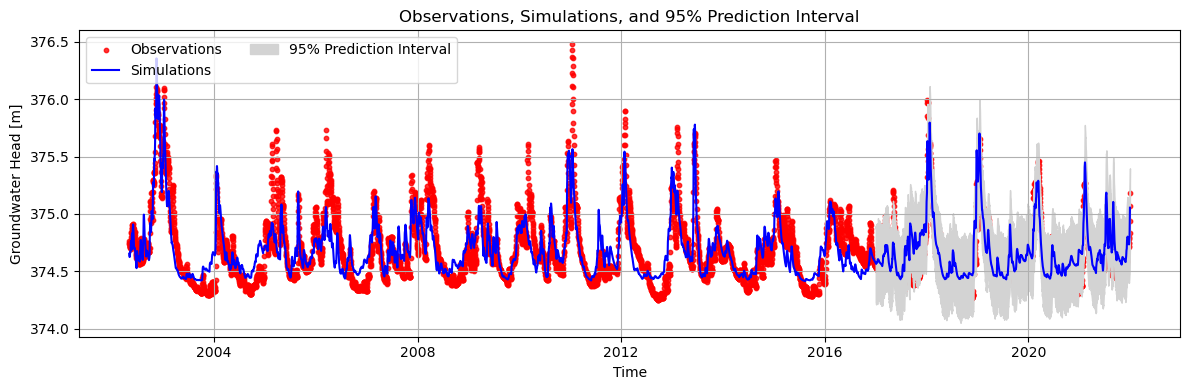

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))


ax.scatter(
    head.index,
    head,
    label="Observations",
    color="red",
    s=10, 
    alpha=0.8,
)


ax.plot(
    heads_sim.index,
    heads_sim,
    label="Simulations",
    color="blue",
    linewidth=1.5,
)


ax.fill_between(
    ci_val.index,
    ci_val.iloc[:, 0],
    ci_val.iloc[:, 1],
    color="lightgray",
    label="95% Prediction Interval",
)


ax.set_title("Observations, Simulations, and 95% Prediction Interval")
ax.set_xlabel("Time")
ax.set_ylabel("Groundwater Head [m]")
ax.legend(loc="upper left", ncol=2)
ax.grid()

plt.show()

**Diagnostics Checking**

A diagnostics check is performed. This is done to ensure that the model adequately describes the observed time series and the noisemodel is performing well.

The check is conducted to test the assumptions for white noise:
- No significant autocorrelation;
- Residuals are homoscedastic;
- Residuals follow a normal distribution.

The results of the diagnostics check show that all tests reject the null hypothesis, meaning that the data do not agree with the assumptions.

In [27]:
ml.stats.diagnostics(alpha=0.05)

p-value may not be accurate for N > 5000.

,Checks,Statistic,P-value,Reject H0 ($\alpha$=0.05)
Shapiroo,Normality,0.74,0.00,True
D'Agostino,Normality,3942.49,0.00,True
Runs test,Autocorr.,-24.44,0.00,True
Ljung-Box,Autocorr.,3931.80,0.00,True
Durbin-Watson,Autocorr.,0.67,nan,False


**Reducing autocorrelation**

Autocorrelation is computed and displayed for time lags from 1 to 365 days. The autocorrelation plot shows that autocorrelation decreases continuously with increasing time lags.

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

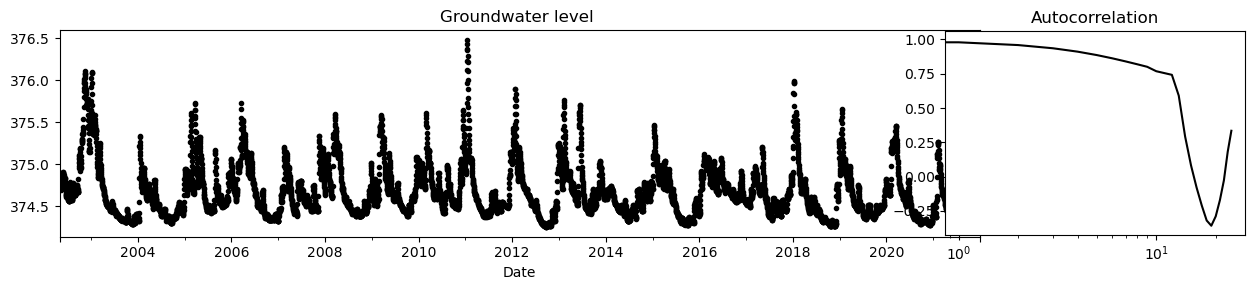

In [28]:
ax = head.plot(figsize=(10, 3), marker=".", linestyle=" ", color="k")
ax1 = plt.axes([0.95, 0.2, 0.3, 0.68])
acf = ps.stats.acf(
    head,
    lags=[
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        12,
        13,
        14,
        30,
        61,
        90,
        120,
        150,
        180,
        210,
        240,
        270,
        300,
        330,
        365,
    ],
).values
ax1.semilogx(acf, color="k") 
ax.set_title("Groundwater level ")
ax1.set_title("Autocorrelation");

In [33]:
mls_ar = {}
dts = 21

rfunc = ps.Exponential()
rch = ps.rch.FlexModel()

for dt in range(1, dts, 2):

    ml_name = f"Germany_{dt}"
    ml = ps.Model(head.iloc[::dt], name=ml_name)
    ml.add_noisemodel(ps.ArNoiseModel())
    sm = ps.RechargeModel(prec, evap, recharge=rch, rfunc=rfunc, name="rch")
    ml.add_stressmodel(sm)

    
    ml.set_parameter(name="rch_ks", initial=10, vary=True,
                     pmin=1, pmax=1000)

    ml.set_parameter(name="rch_A", initial=0.6, vary=True,
                     pmin=0, pmax=1)

    ml.set_parameter(name="rch_a", initial=1.3, vary=True,
                 pmin=0.05, pmax=2)

    ml.set_parameter(name="rch_srmax", initial=300, vary=True,
                     pmin=100, pmax=1000)


    ml.set_parameter(name="rch_gamma", initial=6, vary=True,
                     pmin=5, pmax=10)


    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)
    mls_ar[ml_name] = ml

In [34]:
mls_ar

{'Germany_1': Model(oseries=head, name=Germany_1, constant=True, noisemodel=True),
 'Germany_3': Model(oseries=head, name=Germany_3, constant=True, noisemodel=True),
 'Germany_5': Model(oseries=head, name=Germany_5, constant=True, noisemodel=True),
 'Germany_7': Model(oseries=head, name=Germany_7, constant=True, noisemodel=True),
 'Germany_9': Model(oseries=head, name=Germany_9, constant=True, noisemodel=True),
 'Germany_11': Model(oseries=head, name=Germany_11, constant=True, noisemodel=True),
 'Germany_13': Model(oseries=head, name=Germany_13, constant=True, noisemodel=True),
 'Germany_15': Model(oseries=head, name=Germany_15, constant=True, noisemodel=True),
 'Germany_17': Model(oseries=head, name=Germany_17, constant=True, noisemodel=True),
 'Germany_19': Model(oseries=head, name=Germany_19, constant=True, noisemodel=True)}

The previously created groundwater models (`mls_ar`) are changed to analyze the impact of changing the noise model from autoregressive (AR) to autoregressive-moving-average (ARMA). The modified models are then calibrated and stored for comparison.

Outputs:
- Recalibrated models stored in `mls_arma`.
- Each model is identical to the one in `mls_ar`, except for the noise model type (ARMA instead of AR).

--> a decision can be made about the type of noise model to use.

In [35]:
mls_arma = {}

for ml_name, ml in mls_ar.items():
    ml = ml.copy(name=ml.name)

    
    ml.del_noisemodel()
    ml.add_noisemodel(ps.ArmaNoiseModel())

    
    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)
    mls_arma[ml_name] = ml

The performance of different noise models (AR and ARMA) is evaluated by computing the Durbin-Watson (DW) statistic. The results are plotted to compare the two noise models at varying temporal resolutions (`dt`).

1. **Data preparation**
- Two empty DataFrames (`data` and `data2`) are initialized to store the DW statistic for each temporal resolution (`dt`) and noise model.

2. **Compute DW statistic for AR noise models**
- Loop through all models in `mls_ar` (models with AR noise)

3. **DW statistic for ARMA noise models**
- Loop through all models in `mls_arma` (models with ARMA noise)

4. **Results**
- Two subplots (`ax1` and `ax2`) for AR and ARMA noise models are created, respectively:
  - **AR(1) Noise Model**:
    - Plot of DW statistics from `data` for each `dt`.
    - Dashed line at `DW = 2.0`, indicating no autocorrelation.
  - **ARMA(1,1) Noise Model**:
    - Plot pf DW statistics from `data2` for each `dt`.
    - Dashed line at `DW = 2.0`, indicating no autocorrelation.


The Durbin-Watson statistic is used as the metric:
- **DW = 2.0**: Indicates no autocorrelation.
- **DW < 2.0**: Indicates positive autocorrelation.

Outputs:
- **Two plots** comparing DW statistics for AR(1) and ARMA(1,1) noise models.
- Visual comparison of how the two noise models handle residual autocorrelation across varying temporal resolutions.

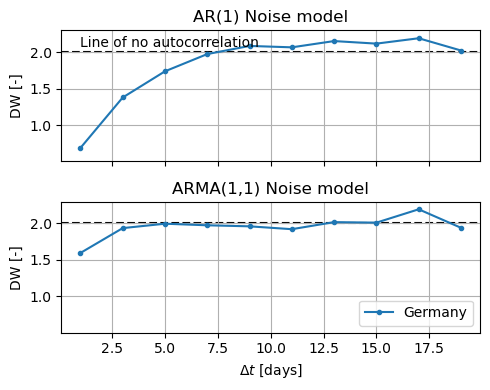

In [36]:
data = pd.DataFrame(index=range(dt, 1), columns=["Germany"])

for ml in mls_ar.values():
    if "Germany" in ml.name:
        name, i = ml.name.split("_")
        n = ml.noise(tmin=tmin_cal, tmax=tmax_val).asfreq(f"{i}D").fillna(0.0)
        data.loc[int(i), name] = ps.stats.durbin_watson(n)[0]

data2 = pd.DataFrame(index=range(dt, 1), columns=["Germany"])

for ml in mls_arma.values():
    if "Germany" in ml.name:
        name, i = ml.name.split("_")
        n = ml.noise(tmin=tmin_cal, tmax=tmax_val).asfreq(f"{i}D").fillna(0.0)
        data2.loc[int(i), name] = ps.stats.durbin_watson(n)[0]

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(5, 4), sharey=True)

# AR1 Model
data.plot(ax=ax1, marker=".", legend=False)
ax1.set_ylabel("DW [-]")
ax1.axhline(2.0, c="k", linestyle="--", zorder=-1)
ax1.text(1, 2.07, "Line of no autocorrelation")
ax1.grid()
ax1.set_title("AR(1) Noise model")

# ArmaModel
data2.plot(ax=ax2, marker=".", legend=False)
ax2.set_ylabel("DW [-]")
ax2.set_yticks([1, 1.5, 2.0])
ax2.axhline(2.0, c="k", linestyle="--", zorder=-10)
ax2.set_ylim(0.5, 2.3)
ax2.grid()
ax2.legend(ncol=3, loc=4)
ax2.set_xlabel("$\\Delta t$ [days]")
ax2.set_title("ARMA(1,1) Noise model")
plt.tight_layout()

The data is split into segments starting at different offsets (`start`), multiple models are created and solved, storing the results. The model is solved with a 5 days time lag, an ARMA(1, 1) noisemodel is added according to the plot above.

1. **Initialization**:
- `mls`: An empty dictionary to store solved models.
- `dt = 5`: Defines the temporal resolution or step size for input data segmentation, chosen based on the previous plots.
- Recharge and response functions:
  - `rfunc`: `Exponential()` for modeling the aquifer response.
  - `rch`: `FlexModel()` for modeling nonlinear recharge dynamics.

2. **Models creation**:
- Loops over starting offsets (`start`) from `0` to `dt - 1` (5 iterations):
  - Creates distinct models by slicing the `head` time series with an offset:
    ```python
    head.iloc[start::dt]
    ```
    This creates sub-series where each model begins at a different temporal offset and uses every `dt`-th observation.

3. **Model configuration**:
- A recharge model (`ps.RechargeModel`) is added to simulate groundwater recharge using the same settings as above.
- Parameters are initialized as above.



5. **Noise model**:
- An ARMA noise model (`ps.ArmaNoiseModel()`) is added.

6. **Model calibration**:
- Each model is solved over the defined calibration period (`tmin_cal` to `tmax_cal`).



Output:
- **5 calibrated models**, each representing a different temporal offset.
  - X-axis: Observation indices adjusted by `start`.
  - Y-axis: Observed and simulated groundwater head.
- Models are stored in the `mls` dictionary, with keys like `Germany_1`, `Germany_2`, etc., corresponding to the starting offsets.


In [38]:
mls_with = {}
dt = 5


rfunc = ps.Exponential()
rch = ps.rch.FlexModel()

for start in range(0, dt, 1):
    ml_name = f"Germany_{start + 1}"
    ml = ps.Model(head.iloc[start::dt], name=ml_name)
    sm = ps.RechargeModel(prec, evap, recharge=rch, rfunc=rfunc, name="rch")
    ml.add_stressmodel(sm)

    # Set parameters for the Nonlinear model
    ml.set_parameter(name="rch_ks", initial=10, vary=True,
                 pmin=1, pmax=1000)

    ml.set_parameter(name="rch_A", initial=0.6, vary=True,
                     pmin=0, pmax=1)

    ml.set_parameter(name="rch_a", initial=1.3, vary=True,
                 pmin=0.05, pmax=2)

    ml.set_parameter(name="rch_srmax", initial=300, vary=True,
                     pmin=100, pmax=1000)


    ml.set_parameter(name="rch_gamma", initial=6, vary=True,
                     pmin=5, pmax=10)

    
    ml.add_noisemodel(ps.ArmaNoiseModel())
    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)

    mls_with[ml_name] = ml
    print(head.iloc[start::dt])

Date
2002-05-01    374.76
2002-05-06    374.71
2002-05-11    374.69
2002-05-16    374.83
2002-05-21    374.90
               ...  
2021-12-07    374.58
2021-12-12    374.66
2021-12-17    374.80
2021-12-22    374.78
2021-12-27    374.79
Name: head, Length: 1437, dtype: float64
Date
2002-05-02    374.75
2002-05-07    374.72
2002-05-12    374.74
2002-05-17    374.84
2002-05-22    374.90
               ...  
2021-12-08    374.60
2021-12-13    374.68
2021-12-18    374.80
2021-12-23    374.75
2021-12-28    374.83
Name: head, Length: 1437, dtype: float64
Date
2002-05-03    374.74
2002-05-08    374.72
2002-05-13    374.75
2002-05-18    374.81
2002-05-23    374.88
               ...  
2021-12-09    374.62
2021-12-14    374.72
2021-12-19    374.81
2021-12-24    374.72
2021-12-29    374.94
Name: head, Length: 1437, dtype: float64
Date
2002-05-04    374.72
2002-05-09    374.71
2002-05-14    374.77
2002-05-19    374.83
2002-05-24    374.87
               ...  
2021-12-10    374.64
2021-12-15    374

The same procedure is repeated without adding the noisemodel.

In [40]:
mls_without = {}
dt = 5


rfunc = ps.Exponential()
rch = ps.rch.FlexModel()

for start in range(0, dt, 1):
    ml_name = f"Germany_{start + 1}"
    ml = ps.Model(head.iloc[start::dt], name=ml_name)
    # Add the recharge model
    sm = ps.RechargeModel(prec, evap, recharge=rch, rfunc=rfunc, name="rch")
    ml.add_stressmodel(sm)

    # Set parameters for the Nonlinear model
    ml.set_parameter(name="rch_ks", initial=10, vary=True,
                 pmin=1, pmax=1000)

    ml.set_parameter(name="rch_A", initial=0.6, vary=True,
                     pmin=0, pmax=1)

    ml.set_parameter(name="rch_a", initial=1.3, vary=True,
                 pmin=0.05, pmax=2)

    ml.set_parameter(name="rch_srmax", initial=300, vary=True,
                     pmin=100, pmax=1000)


    ml.set_parameter(name="rch_gamma", initial=6, vary=True,
                     pmin=5, pmax=10)



    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)

    mls_without[ml_name] = ml

In this code cell the parameter estimates and uncertainties for models with and without noisemodels are organized in `df_with` and `df_without`.

In [41]:
data = {}

name = "Germany"
ml = mls_with["{}_1".format(name)]
p = ml.parameters
mi = pd.MultiIndex.from_product([p.index[p.vary].to_list(), ["opt", "std"]])
data[name] = pd.DataFrame(data=np.nan, index=range(dt, 1), columns=mi, dtype=float)

for ml in mls_with.values():
    if "Germany" in ml.name:
        name, i = ml.name.split("_")
        df = data[name]
        for par in ml.parameters.index[ml.parameters.vary]:
            df.loc[int(i), (par, "opt")] = ml.parameters.loc[par, "optimal"]
            df.loc[int(i), (par, "std")] = ml.parameters.loc[par, "stderr"]

df_with = pd.concat(data, axis=1)
df_with

Germany                                                                \
      rch_A           rch_a             rch_srmax                  rch_ks   
        opt       std   opt       std         opt         std         opt   
1  0.463258  0.023920   2.0  0.155801  481.726706  210.346982  180.730792   
2  0.470723  0.024098   2.0  0.160851  506.369251  218.256379  194.028284   
3  0.496714  0.026080   2.0  0.176726  614.658403  252.466567  311.588411   
4  0.480644  0.026754   2.0  0.192812  629.199291  252.756423  406.776760   
5  0.458874  0.025300   2.0  0.176877  567.016071  223.701941  366.694037   

                                                                             \
              rch_gamma              rch_kv            constant_d             
          std       opt       std       opt       std         opt       std   
1  385.382412       5.0  0.979510  0.747891  0.024711  374.421679  0.022130   
2  409.678820       5.0  0.995467  0.740005  0.023809  374.414085  0.022488   
3  654.597716       5.0  1.042085  0.737128  0.028450  374.391745  0.024215   
4  852.847681       5.0  1.020319  0.749452  0.036956  374.399826  0.024504   
5  751.690031       5.0  0.971935  0.758797  0.036160  374.416612  0.023310   

                                              
  noise_alpha           noise_beta            
          opt       std        opt       std  
1   18.423432  2.147590   3.538862  0.362555  
2   18.441331  2.140762   3.578576  0.364243  
3   17.791966  2.069405   3.400896  0.361178  
4   18.541336  2.219763   2.869267  0.345806  
5   19.515488  2.331228   3.149562  0.347439

In [42]:
data = {}

name = "Germany"
ml = mls_without["{}_1".format(name)]
p = ml.parameters
mi = pd.MultiIndex.from_product([p.index[p.vary].to_list(), ["opt", "std"]])
data[name] = pd.DataFrame(data=np.nan, index=range(dt, 1), columns=mi, dtype=float)

for ml in mls_without.values():
    if "Germany" in ml.name:
        name, i = ml.name.split("_")
        df = data[name]
        for par in ml.parameters.index[ml.parameters.vary]:
            df.loc[int(i), (par, "opt")] = ml.parameters.loc[par, "optimal"]
            df.loc[int(i), (par, "std")] = ml.parameters.loc[par, "stderr"]

df_without = pd.concat(data, axis=1)
p

,initial,pmin,pmax,vary,name,dist,stderr,optimal
rch_A,0.600000,0.00000,1.0,True,rch,uniform,0.011367,0.502942
rch_a,1.300000,0.05000,2.0,True,rch,uniform,0.304892,1.401790
rch_srmax,300.000000,100.00000,1000.0,True,rch,uniform,186.990304,467.958574
rch_lp,0.250000,0.00001,1.0,False,rch,uniform,NaN,0.250000
rch_ks,10.000000,1.00000,1000.0,True,rch,uniform,79.209363,44.320769
rch_gamma,6.000000,5.00000,10.0,True,rch,uniform,0.737566,5.000000
rch_kv,1.000000,0.25000,2.0,True,rch,uniform,0.011262,0.752180
rch_simax,2.000000,0.00000,10.0,False,rch,uniform,NaN,2.000000
constant_d,374.669322,NaN,NaN,True,constant,uniform,0.011274,374.430148


### Parameter Variability Across Models

This code plots error bars to compare parameter variability across models with and without a noise model.

- Extracts models & parameters from `df_with`.
- Creates subplots for each parameter.
- Loops through parameters, checking for `opt` (optimized values) and `std` (standard deviation).
- Plots error bars for both datasets (`df_with` and `df_without`), showing uncertainty.
- Formats plots with labels, legends, grid lines, and a shared x-axis.
- Skips missing parameters and prints a message.

The result visualizes how the noise model affects different parameters as well as the influence of starting the simulation from different timesteps.

Skipping noise_alpha, columns not found in df.
Skipping noise_beta, columns not found in df.


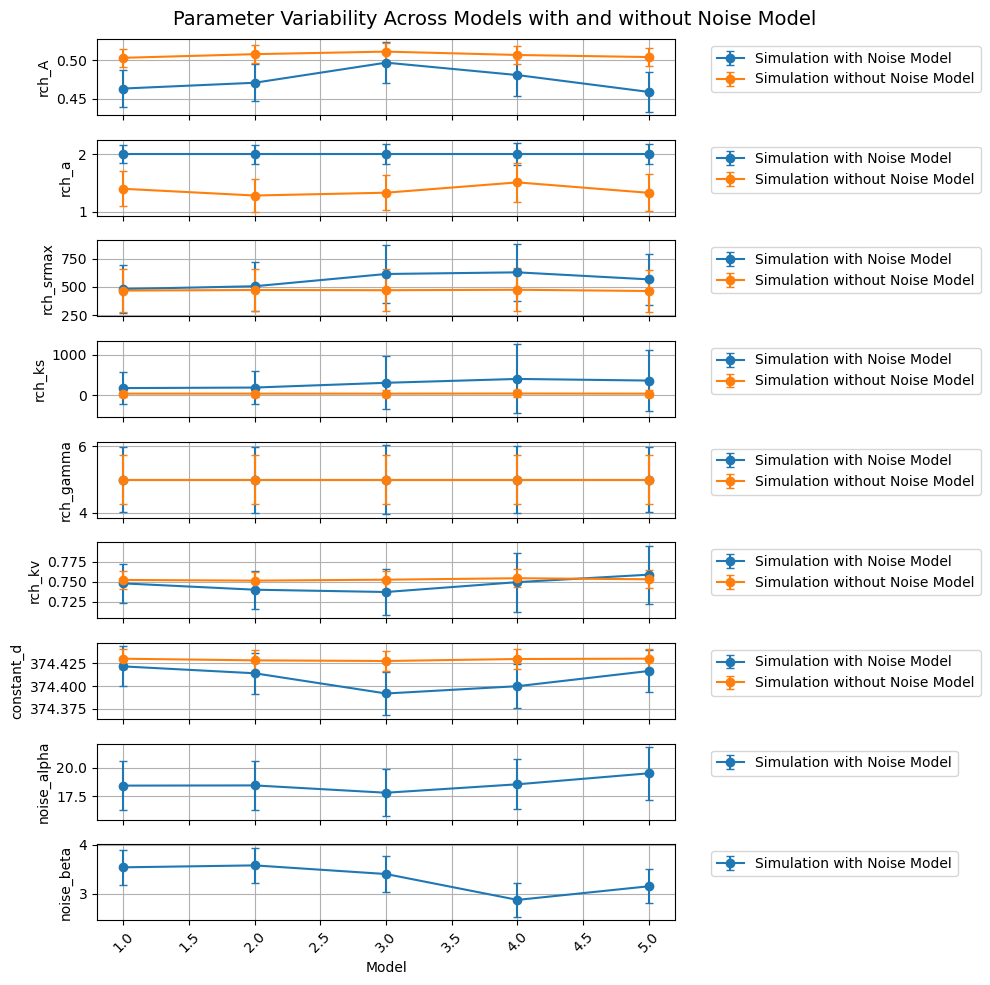

In [43]:
models = df_with.index
std_avg_with = []
std_avg_without = []
parameters = df_with["Germany"].columns.get_level_values(0).unique()

fig, axes = plt.subplots(len(parameters), 1, figsize=(10, 10), sharex=True)

for i, param in enumerate(parameters):
    if ("Germany", param, "opt") in df_with.columns and ("Germany", param, "std") in df_with.columns:
        opt_with = df_with[("Germany", param, "opt")]
        std_with = df_with[("Germany", param, "std")]
        std_avg_with.append(std_with.mean())

        axes[i].errorbar(df_with.index, opt_with, yerr=std_with, fmt="-o", capsize=3, label = "Simulation with Noise Model")
        axes[i].set_ylabel(param)
        axes[i].grid(True)
        axes[i].legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True)
    else:
        print(f"Skipping {param}, columns not found in df.")
        
    if ("Germany", param, "opt") in df_without.columns and ("Germany", param, "std") in df_without.columns:
        opt_without = df_without[("Germany", param, "opt")]
        std_without = df_without[("Germany", param, "std")]
        std_avg_without.append(std_with.mean())

        axes[i].errorbar(df_without.index, opt_without, yerr=std_without, fmt="-o", capsize=3, label = "Simulation without Noise Model")
        axes[i].set_ylabel(param)
        axes[i].grid(True)
        axes[i].legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True)
    else:
        print(f"Skipping {param}, columns not found in df.")

axes[-1].set_xlabel("Model")
fig.suptitle("Parameter Variability Across Models with and without Noise Model", fontsize=14)


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The uncertainty behind the parameters is quantified by computing the standard deviation for both models with and without the noisemodel. Please note that the parameters uncertainty is normalized using the absolute value of the parameter itself.

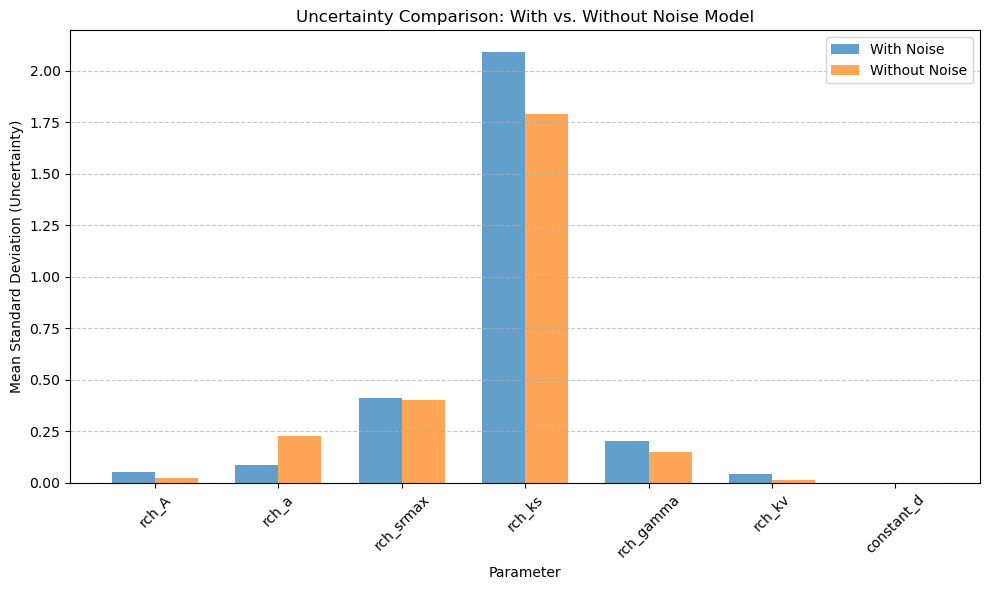

In [44]:
std_avg_with = [df_with[("Germany", param, "std")].mean() / df_with[("Germany", param, "opt")].mean()for param in parameters[:-2]]
std_avg_without = [df_without[("Germany", param, "std")].mean() / df_without[("Germany", param, "opt")].mean()for param in parameters[:-2]]



uncertainty_df = pd.DataFrame({
    "Parameter": parameters[:-2],
    "With Noise": std_avg_with,
    "Without Noise": std_avg_without
})


fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(parameters[:-2]))

bars1 = ax.bar(index, std_avg_with, bar_width, label='With Noise', alpha=0.7)
bars2 = ax.bar(index + bar_width, std_avg_without, bar_width, label='Without Noise', alpha=0.7)

ax.set_xlabel('Parameter')
ax.set_ylabel('Mean Standard Deviation (Uncertainty)')
ax.set_title('Uncertainty Comparison: With vs. Without Noise Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(parameters[:-2], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


The statistical diagnostics of the previously calibrated groundwater models stored in the `mls_with` dictionary is performed.

In [45]:
for name, model in mls_with.items():
    print(f"Model name: {name}")
    print(model.stats.diagnostics(alpha=0.05))

Model name: Germany_1
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.78    0.00                       True
D'Agostino     Normality    771.90    0.00                       True
Runs test      Autocorr.     -4.77    0.00                       True
Ljung-Box      Autocorr.      3.85    0.05                       True
Durbin-Watson  Autocorr.      2.03     nan                      False
Model name: Germany_2
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.79    0.00                       True
D'Agostino     Normality    708.74    0.00                       True
Runs test      Autocorr.     -5.13    0.00                       True
Ljung-Box      Autocorr.      4.64    0.03                       True
Durbin-Watson  Autocorr.      2.03     nan                      False
Model name: Germany_3
                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality

Autocorrelation is visually inspected and a Stoffer-Toloi check is computed, both showing positive results, there is no significant autocorrelation.

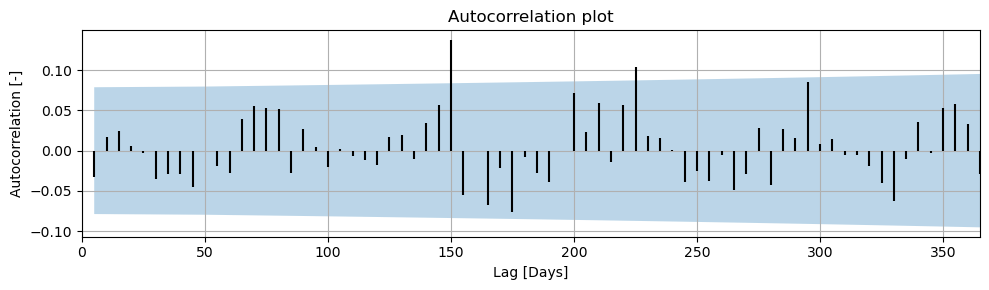

In [49]:
model_with = mls_with["Germany_4"]
model_without = mls_without["Germany_4"]
noise = model_with.noise()
ax = ps.plots.acf(noise, acf_options=dict(bin_width=0.5), figsize=(10, 3), alpha=0.01)

In [50]:
stat, p = ps.stats.stoffer_toloi(noise, lags=5)

if p > 0.5:
    print(
        "Failed to reject the Null-hypothesis, no significant autocorrelation. p =",
        p.round(2),
    )
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Reject the Null-hypothesis. p = 0.2


**Normality Checking**

Normality is checked visually by looking at the probability plot and at the histogram of the residuals with a normal distribution fit to it.

The distribution is skewed to the left and shows a narrow bell shape.
Points at the upper tail deviate substantially from the line of perfect normality.

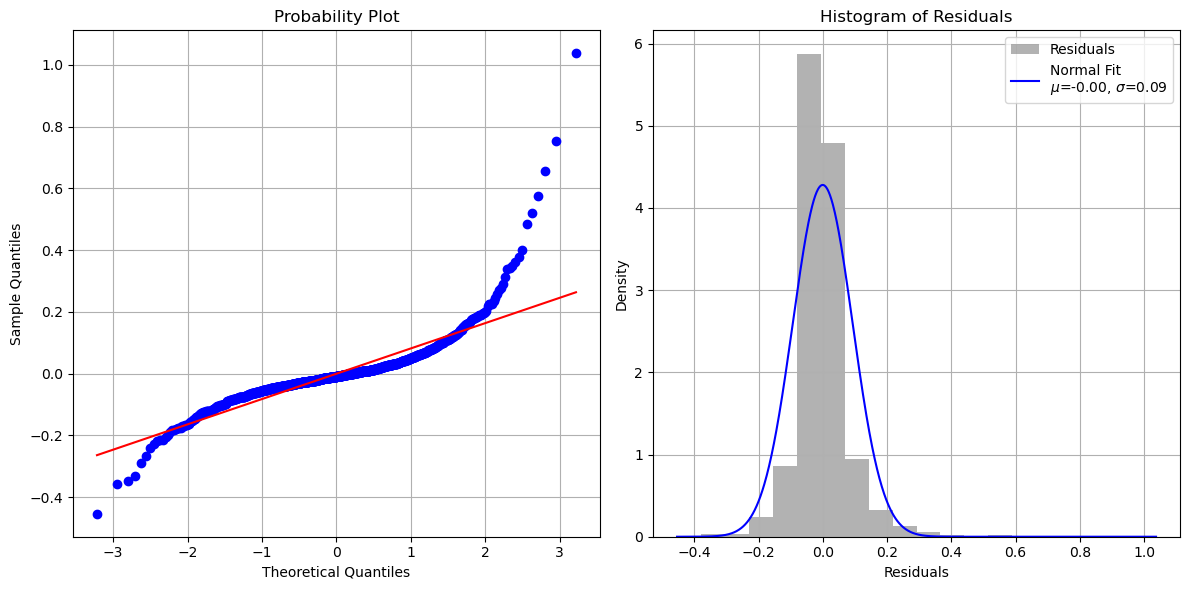

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


stats.probplot(noise, dist="norm", plot=axes[0])
axes[0].set_title("Probability Plot")
axes[0].set_xlabel("Theoretical Quantiles")
axes[0].set_ylabel("Sample Quantiles")
axes[0].grid()

axes[1].hist(noise, bins=20, density=True, alpha=0.6, color="gray", label="Residuals")


mu, std = stats.norm.fit(noise)
x = np.linspace(min(noise), max(noise), 1000)
pdf = stats.norm.pdf(x, loc=mu, scale=std)
axes[1].plot(x, pdf, color="blue", label=f"Normal Fit\n$\mu$={mu:.2f}, $\sigma$={std:.2f}")
axes[1].set_title("Histogram of Residuals")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [52]:
stat, p = stats.normaltest(noise)

if p > 0.5:
    print(
        "Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =",
        p.round(2),
    )
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Reject the Null-hypothesis. p = 0.0


**Homoscedasticity Checking**

Homoscedasticity is visually inspected, the goal is to check wheter values of the residuals are independent of the observed groundwater levels.

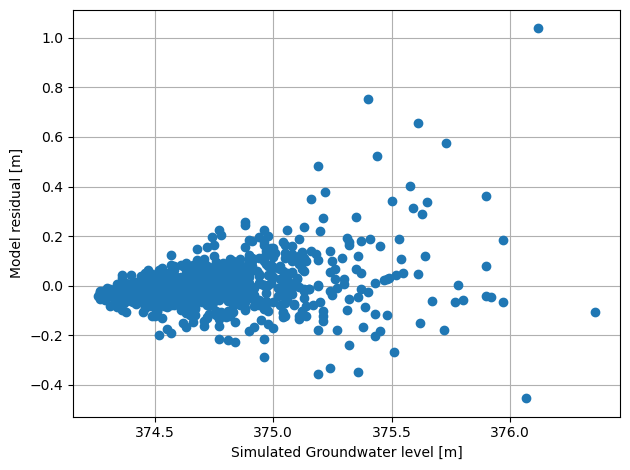

In [53]:
plt.plot(model_with.observations(), model_with.noise(), marker="o", linestyle=" ")
plt.xlabel("Simulated Groundwater level [m]")
plt.ylabel("Model residual [m]")
plt.grid()

The performance of the model is assessed using two different metrics, as requested from the groundwater challenge.  
The metrics applied are:
- Nash-Sutcliffe Efficiency (NSE) over the two periods;
- Mean Absolute Error (MAE) over heads value below the 0.2 quantile and above the 0.8 quantile for both calibration and validation periods.  

The results show better fit in the calibration period, with better representation of low end values.

In [54]:
sim_cal_with = model_with.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val_with = model_with.simulate(tmin = tmin_val, tmax = tmax_val)
heads_sim_with = model_with.simulate(tmin = tmin_cal, tmax = tmax_val)

nse_cal_with = ps.stats.metrics.nse(obs = head_cal, sim = sim_cal_with)
nse_val_with = ps.stats.metrics.nse(obs = head_val, sim = sim_val_with)

q02_obs_cal_with = head_cal[head_cal <= head_cal.quantile(0.2)]
q02_sim_cal_with = sim_cal_with.loc[q02_obs_cal_with.index]

q02_obs_val_with = head_val[head_val <= head_val.quantile(0.2)]
q02_sim_val_with = sim_val_with.loc[q02_obs_val_with.index]


q08_obs_cal_with = head_cal[head_cal <= head_cal.quantile(0.8)]
q08_sim_cal_with = sim_cal_with.loc[q08_obs_cal_with.index]

q08_obs_val_with = head_val[head_val <= head_val.quantile(0.8)]
q08_sim_val_with = sim_val_with.loc[q08_obs_val_with.index]

mae_cal02_with = ps.stats.metrics.mae(obs = q02_obs_cal_with, sim = q02_sim_cal_with)
mae_cal08_with = ps.stats.metrics.mae(obs = q08_obs_cal_with, sim = q08_sim_cal_with)

mae_val02_with = ps.stats.metrics.mae(obs = q02_obs_val_with, sim = q02_sim_val_with)
mae_val08_with = ps.stats.metrics.mae(obs = q08_obs_val_with, sim = q08_sim_val_with)


print(f"Results of fit test with noisemodel:\n"
      f"  - NSE over calibration period: {nse_cal_with:.4f}.\n"
      f"  - MAE_02 over calibration period: {mae_cal02_with:.4f}.\n"
      f"  - MAE_08 over calibration period: {mae_cal08_with:.4f}.\n"
      "\n"
      f"  - NSE over validation period: {nse_val_with:.4f}.\n"
      f"  - MAE_02 over validation period: {mae_val02_with:.4f}.\n"
      f"  - MAE_08 over validation period: {mae_val08_with:.4f}.\n")

Results of fit test with noisemodel:
  - NSE over calibration period: 0.7294.
  - MAE_02 over calibration period: 0.1013.
  - MAE_08 over calibration period: 0.1020.

  - NSE over validation period: 0.6394.
  - MAE_02 over validation period: 0.1448.
  - MAE_08 over validation period: 0.1303.



In [55]:
sim_cal_without = model_without.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val_without = model_without.simulate(tmin = tmin_val, tmax = tmax_val)
heads_sim_without = model_without.simulate(tmin = tmin_cal, tmax = tmax_val)

nse_cal_without = ps.stats.metrics.nse(obs = head_cal, sim = sim_cal_without)
nse_val_without = ps.stats.metrics.nse(obs = head_val, sim = sim_val_without)

q02_obs_cal_without = head_cal[head_cal <= head_cal.quantile(0.2)]
q02_sim_cal_without = sim_cal_without.loc[q02_obs_cal_without.index]

q02_obs_val_without = head_val[head_val <= head_val.quantile(0.2)]
q02_sim_val_without = sim_val_without.loc[q02_obs_val_without.index]

q08_obs_cal_without = head_cal[head_cal <= head_cal.quantile(0.8)]
q08_sim_cal_without = sim_cal_without.loc[q08_obs_cal_without.index]

q08_obs_val_without = head_val[head_val <= head_val.quantile(0.8)]
q08_sim_val_without = sim_val_without.loc[q08_obs_val_without.index]

mae_cal02_without = ps.stats.metrics.mae(obs = q02_obs_cal_without, sim = q02_sim_cal_without)
mae_cal08_without = ps.stats.metrics.mae(obs = q08_obs_cal_without, sim = q08_sim_cal_without)

mae_val02_without = ps.stats.metrics.mae(obs = q02_obs_val_without, sim = q02_sim_val_without)
mae_val08_without = ps.stats.metrics.mae(obs = q08_obs_val_without, sim = q08_sim_val_without)


print(f"Results of fit test without noisemodel:\n"
      f"  - NSE over calibration period: {nse_cal_without:.4f}.\n"
      f"  - MAE_02 over calibration period: {mae_cal02_without:.4f}.\n"
      f"  - MAE_08 over calibration period: {mae_cal08_without:.4f}.\n"
      "\n"
      f"  - NSE over validation period: {nse_val_without:.4f}.\n"
      f"  - MAE_02 over validation period: {mae_val02_without:.4f}.\n"
      f"  - MAE_08 over validation period: {mae_val08_without:.4f}.\n")

Results of fit test without noisemodel:
  - NSE over calibration period: 0.7746.
  - MAE_02 over calibration period: 0.0951.
  - MAE_08 over calibration period: 0.0897.

  - NSE over validation period: 0.7037.
  - MAE_02 over validation period: 0.1279.
  - MAE_08 over validation period: 0.1144.



The performance metrics show that the model without noisemodel performs better both in the validation and calibration periods.

The quality of the 95% prediction interval is tested by computing the Prediction Interval Coverage Probability (PICP) to assess the share of values falling the wanted interval.  
The computed PICP is close to 95% for all three periods.

In [56]:
periods = [(ci_cal, head_cal, "Calibration"), (ci_val, head_val, "Validation"), (ci_tot, heads_sim, "Total")]


for period in periods:
    low = period[0].iloc[:, 0].reindex(period[1].index)
    up = period[0].iloc[:, 1].reindex(period[1].index)
    bound = pd.DataFrame({'low': low, 'up': up})
    within = period[1][(period[1] >= low) & (period[1] <= up)]

    #PICP = len(within)/len(low)*100
    PICP = ps.stats.picp(period[1], bound) #new pastas feature
    print(f"The computed PICP in the {period[2]} Period is: {PICP:.3f}.")

The computed PICP in the Calibration Period is: 0.954.
The computed PICP in the Validation Period is: 0.967.
The computed PICP in the Total Period is: 1.000.
